In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Two Towers Architecture

Question Embeddings ->  Q_E

Answer Embeddings -> Dense Layer -> A_E

dot product ( Q_E , A_E )  -> Softmax prediction probability


Input: 
Q_E = [1,512]
A_E = [1,512]

Output:
Softmax Probability

This model:
- Embeds questions (including text and code) using USE
- Embeds answers (including text and code) using USE


# Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import random
import pickle
import os
import datetime

from numpy.linalg import norm
from scipy.stats import rankdata

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorboard.plugins.hparams import api as hp

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from itertools import product

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/master/helper_functions')
import similarity_score_dicts
import evaluation

# Load TensorBoard
%load_ext tensorboard

# Create Train_x and Train_y

Train_x_q = List of Question Embeddings  
Train_x_a = List of Answer Embeddings
Train_y = [1 or 0] for each Q&A pair

Dev and Test sets are similiar


In [3]:
# Load embeddings dictionary from file
use_embeddings_from_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/embeddings/use_embeddings.pickle', 'rb')
use_embeddings = pickle.load(use_embeddings_from_file)

print("length of dictionary:", len(use_embeddings.keys()))
print("length of each embedding:", len(use_embeddings[55661532]))
print(type(use_embeddings))

length of dictionary: 90959
length of each embedding: 1
<class 'dict'>


In [ ]:
#use_embeddings[55661532]

In [4]:
# Q_A dictionary

train_from_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/q_a_dict_train.pickle', 'rb')
qa_dict_train = pickle.load(train_from_file)

dev_from_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/q_a_dict_dev.pickle', 'rb')
qa_dict_dev = pickle.load(dev_from_file)

test_from_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/q_a_dict_test.pickle', 'rb')
qa_dict_test = pickle.load(test_from_file)

print("Train / Dev / Test:", len(qa_dict_train), "/", len(qa_dict_dev), "/", len(qa_dict_test))
print(list(qa_dict_train.keys())[0])
print(qa_dict_train[55661532])

Train / Dev / Test: 24498 / 3062 / 3063
55661532
[(55661630, 0), (55661552, 1), (36904214, 0), (48880105, 0), (47364166, 0), (63461107, 0), (47667820, 0), (38621558, 0), (63534457, 0), (45136194, 0)]


In [ ]:
#Create Train X and Train Y

train_x_q = []   #list of Question embeddings (512 dimension)
train_x_a = []   #list of Answer embeddings (512 dimension)
train_y = []   #list of answer labels (1 or 0's)

embedding = use_embeddings

for question in list(qa_dict_train.keys()):
  for answer in qa_dict_train[question]:
    question_reshaped = tf.reshape(embedding[question], [-1])
    train_x_q.append(question_reshaped)

    answer_reshaped = tf.reshape(embedding[answer[0]], [-1])
    train_x_a.append(answer_reshaped)

    if answer[1] == 1:
      train_y.append(1)
    else:
      train_y.append(0)

train_x_q = np.array(train_x_q)
train_x_a = np.array(train_x_a)
train_y = np.array(train_y)

print("Train_x_q length:", len(train_x_q))
print("Train_x_a length:", len(train_x_a))
print("Train_y length:", len(train_y))


Train_x_q length: 244980
Train_x_a length: 244980
Train_y length: 244980


In [ ]:
#ERROR CHECKING
ID = list(qa_dict_train.keys())[0]
print("Q_ID:", ID)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(qa_dict_train[ID])
print(train_y[0:10])
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
embed_idx=1
print(use_embeddings[ID][0][embed_idx])   #these two q_embeddings should be same
print(train_x_q[0][embed_idx])          #these two q_embeddings should be same
# print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
A_ID = qa_dict_train[ID][0][0]
print("A_ID:", A_ID)
print(use_embeddings[A_ID][0][embed_idx])      #these two a_embeddings should be same
print(train_x_a[0][embed_idx])               #these two a_embeddings should be same

Q_ID: 55661532
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[(55661630, 0), (55661552, 1), (36904214, 0), (48880105, 0), (47364166, 0), (63461107, 0), (47667820, 0), (38621558, 0), (63534457, 0), (45136194, 0)]
[0 1 0 0 0 0 0 0 0 0]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
tf.Tensor(0.033920534, shape=(), dtype=float32)
0.033920534
A_ID: 55661630
tf.Tensor(-0.04884132, shape=(), dtype=float32)
-0.04884132


In [ ]:
#Repeat for Dev

dev_x_q = []   #list of Question embeddings (512 dimension)
dev_x_a = []   #list of Answer embeddings (512 dimension)
dev_y = []   #list of answer labels (1 or 0's)

embedding = use_embeddings   #specify embedding

for question in list(qa_dict_dev.keys()):
  for answer in qa_dict_dev[question]:
    question_reshaped = tf.reshape(embedding[question], [-1])
    dev_x_q.append(question_reshaped)

    answer_reshaped = tf.reshape(embedding[answer[0]], [-1])
    dev_x_a.append(answer_reshaped)

    if answer[1] == 1:
      dev_y.append(1)
    else:
      dev_y.append(0)

dev_x_q = np.array(dev_x_q)
dev_x_a = np.array(dev_x_a)
dev_y = np.array(dev_y)

print("Dev_x_q length:", len(dev_x_q))
print("Dev_x_a length:", len(dev_x_a))
print("Dev_y length:", len(dev_y))

Dev_x_q length: 30620
Dev_x_a length: 30620
Dev_y length: 30620


In [5]:
#Repeat for Test

test_x_q = []   #list of Question embeddings (512 dimension)
test_x_a = []   #list of Answer embeddings (512 dimension)
test_y = []   #list of answer labels (1 or 0's)

embedding = use_embeddings   #specify embedding

for question in list(qa_dict_test.keys()):
  for answer in qa_dict_test[question]:
    question_reshaped = tf.reshape(embedding[question], [-1])
    test_x_q.append(question_reshaped)

    answer_reshaped = tf.reshape(embedding[answer[0]], [-1])
    test_x_a.append(answer_reshaped)

    if answer[1] == 1:
      test_y.append(1)
    else:
      test_y.append(0)

print("Test_x_q length:", len(test_x_q))
print("Test_x_a length:", len(test_x_a))
print("Test_y length:", len(test_y))

test_x_q = np.array(test_x_q)
test_x_a = np.array(test_x_a)
test_y = np.array(test_y)

Test_x_q length: 30630
Test_x_a length: 30630
Test_y length: 30630


# Build 2 Towers Neural Network

In [ ]:
# Create model
def create_model(num_units):
  #Left Tower
  q_embed = keras.layers.Input(shape=(512,))

  #Right Tower
  a_embed = keras.layers.Input(shape=(512,))
  a_dense_layer = keras.layers.Dense(num_units, activation='relu')(a_embed)

  #Fusion/Dot Product
  dot_product = keras.layers.dot( [q_embed, a_dense_layer], axes =1)

  #Softmax
  prediction = keras.layers.Dense(2, activation='softmax')(dot_product)

  #Model
  model = keras.Model(inputs=[q_embed, a_embed], outputs=prediction)

  return model

In [ ]:
# Define hyperparameters
num_units = [512]
learning_rate = [0.0003, 0.0001, 0.001, 0.01, 0.1]

hyperparams = list(product(num_units, learning_rate))
print(hyperparams)

[(512, 0.0003), (512, 0.0001), (512, 0.001), (512, 0.01), (512, 0.1)]


In [ ]:
# Write hyperparams to a dataframe
hp = {
    'Number of Units': [i[0] for i in hyperparams],
    'Learning Rate': [i[1] for i in hyperparams]
}

hp_df = pd.DataFrame(hp, columns = ['Number of Units', 'Learning Rate'])
hp_df

,Number of Units,Learning Rate
0,512,0.0003
1,512,0.0001
2,512,0.0010
3,512,0.0100
4,512,0.1000


In [ ]:
for units in num_units:
  model = create_model(units)
  # Plot the model; Pass in custom file path as a parameter
  plot_model(model, to_file = '/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/model_' + str(units) + '.png', show_shapes=True, show_layer_names=True)
  model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          262656      input_2[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1)            0           input_1[0][0]                    
                                                                 dense[0][0]                  

# Train Model

In [ ]:
def train_model(num_units, learning_rate):
  model = create_model(num_units)
  opt = optimizers.Adam(learning_rate = learning_rate)
  model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

  # Modify to use your custom path for tensorboard
  logdir = os.path.join("/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit([train_x_q, train_x_a], train_y, validation_data=([dev_x_q, dev_x_a], dev_y), epochs=2, batch_size=64, callbacks=[tensorboard_callback])

  return model

In [ ]:
trained_models = []
count = 0

for params in hyperparams:
  count += 1
  print('Model ' + str(count) + ': [num_units = ' + str(params[0]) + ', learning_rate = ' + str(params[1]) + ']')
  model = train_model(params[0], params[1])
  trained_models.append((model, model.history))
  print()

Model 1: [num_units = 512, learning_rate = 0.0003]
Epoch 1/2
3828/3828 [==============================] - 20s 5ms/step - loss: 0.3038 - accuracy: 0.8995 - val_loss: 0.2175 - val_accuracy: 0.9072
Epoch 2/2
3828/3828 [==============================] - 18s 5ms/step - loss: 0.2097 - accuracy: 0.9087 - val_loss: 0.2006 - val_accuracy: 0.9093

Model 2: [num_units = 512, learning_rate = 0.0001]
Epoch 1/2
3828/3828 [==============================] - 19s 5ms/step - loss: 0.3904 - accuracy: 0.8980 - val_loss: 0.2942 - val_accuracy: 0.9000
Epoch 2/2
3828/3828 [==============================] - 18s 5ms/step - loss: 0.2835 - accuracy: 0.8998 - val_loss: 0.2540 - val_accuracy: 0.9012

Model 3: [num_units = 512, learning_rate = 0.001]
Epoch 1/2
3828/3828 [==============================] - 19s 5ms/step - loss: 0.2717 - accuracy: 0.9003 - val_loss: 0.2036 - val_accuracy: 0.9098
Epoch 2/2
3828/3828 [==============================] - 17s 5ms/step - loss: 0.1927 - accuracy: 0.9143 - val_loss: 0.1987 - val

In [ ]:
# Launch TensorBoard (Use your custom path)
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/logs/'

In [ ]:
# Add training results into new columns in hyperparameter dataframe

num_epochs = 2 # modify this count to however many epochs you trained on

training_loss = []
training_accuracy = []
val_loss = []
val_accuracy = []

# Loop through the model histories
for hist in trained_models:
  training_loss.append(hist[1].history['loss'][num_epochs - 1])
  training_accuracy.append(hist[1].history['accuracy'][num_epochs - 1])
  val_loss.append(hist[1].history['val_loss'][num_epochs - 1])
  val_accuracy.append(hist[1].history['val_accuracy'][num_epochs - 1])

# Add new loss and accuracy columns to hyperparameter dataframe
hp_df['Training Loss'] = training_loss
hp_df['Training Accuracy'] = training_accuracy
hp_df['Validation Loss'] = val_loss
hp_df['Validation Accuracy'] = val_accuracy

In [ ]:
hp_df

,Number of Units,Learning Rate,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,512,0.0003,0.206224,0.909054,0.200577,0.909340
1,512,0.0001,0.272586,0.900396,0.254008,0.901176
2,512,0.0010,0.193991,0.912924,0.198726,0.910581
3,512,0.0100,0.196422,0.912732,0.205347,0.910091
4,512,0.1000,0.214039,0.909246,0.240529,0.900947


In [ ]:
question_ids = list(qa_dict_dev.keys())
count = 0

val_mrr = []
val_precision = []
val_recall = []
val_accuracy_adjusted = []

# Loop through each model
for m in trained_models:
  count += 1
  print("Model " + str(count))
  print("----------")

  # Predict on dev data
  preds = m[0].predict([dev_x_q, dev_x_a])

  #Creates a dictionary with keys that are question ids and values that are tuples of answer id and probability
  #{'question_id' => [10('answer_id', probability)]}
  predictions_dict = {}
  prediction_num = 0
  for q_id in question_ids:
    predictions_dict[q_id] = []
    for a_id in qa_dict_dev[q_id]:
      predictions_dict[q_id].append((a_id[0], preds[prediction_num][1]))
      prediction_num += 1
  
  # Compute rankings
  preds_ranking_dict = similarity_score_dicts.compute_rankings(predictions_dict)

  # Compute MRR
  mrr = evaluation.calculate_mrr(qa_dict_dev, preds_ranking_dict)

  # Compute precision, recall, and adjusted accuracy
  try:
    precision, recall, accuracy_adj = evaluation.calculate_metrics(qa_dict_dev, preds_ranking_dict)
  except ZeroDivisionError as e:
    print(e)
    precision = 0
    recall = 0
    accuracy_adj = 0

  val_mrr.append(mrr)
  val_precision.append(precision)
  val_recall.append(recall)
  val_accuracy_adjusted.append(accuracy_adj)
  print()

# Add new metric columns to hyperparameter dataframe
hp_df['Validation MRR'] = val_mrr
hp_df['Validation Precision'] = val_precision
hp_df['Validation Recall'] = val_recall
hp_df['Validation Accuracy Adjusted'] = val_accuracy_adjusted

Model 1
----------
MRR: 0.789847386810156
TP: 1965
FP: 1093
TN: 26460
FN: 1102
Precision: 0.6425768476128189
Recall: 0.6406912292142158
Accuracy: 0.928314826910516

Model 2
----------
MRR: 0.7237823084818501
TP: 1702
FP: 1356
TN: 26197
FN: 1365
Precision: 0.5565729234793984
Recall: 0.5549396804695141
Accuracy: 0.9111365120836055

Model 3
----------
MRR: 0.7936082859009054
TP: 1987
FP: 1073
TN: 26480
FN: 1080
Precision: 0.6493464052287582
Recall: 0.6478643625692859
Accuracy: 0.9296864794252123

Model 4
----------
MRR: 0.7801166111992367
TP: 1922
FP: 1138
TN: 26415
FN: 1145
Precision: 0.6281045751633987
Recall: 0.6266710140202152
Accuracy: 0.9254408883082952

Model 5
----------
MRR: 0.7587724072864486
TP: 1839
FP: 1221
TN: 26332
FN: 1228
Precision: 0.6009803921568627
Recall: 0.5996087381806325
Accuracy: 0.9200195950359242



In [ ]:
question_ids = list(qa_dict_dev.keys())

# Loop through each model
for m in trained_models:
  # Predict on dev data
  preds = m[0].predict([dev_x_q, dev_x_a])

  #Creates a dictionary with keys that are question ids and values that are tuples of answer id and probability
  #{'question_id' => [10('answer_id', probability)]}
  predictions_dict = {}
  prediction_num = 0
  for q_id in question_ids:
    predictions_dict[q_id] = []
    for a_id in qa_dict_dev[q_id]:
      predictions_dict[q_id].append((a_id[0], preds[prediction_num][1]))
      prediction_num += 1
  
  # Compute rankings
  preds_ranking_dict = similarity_score_dicts.compute_rankings(predictions_dict)

  # Compute MRR
  mrr = evaluation.calculate_mrr(qa_dict_dev, preds_ranking_dict)

  # Compute precision, recall, and adjusted accuracy
  try:
    precision, recall, accuracy_adj = evaluation.calculate_metrics(qa_dict_dev, preds_ranking_dict)
  except ZeroDivisionError as e:
    print(e)
    precision = 0
    recall = 0
    accuracy_adj = 0

MRR: 0.789847386810156
TP: 1965
FP: 1093
TN: 26460
FN: 1102
Precision: 0.6425768476128189
Recall: 0.6406912292142158
Accuracy: 0.928314826910516
MRR: 0.7237823084818501
TP: 1702
FP: 1356
TN: 26197
FN: 1365
Precision: 0.5565729234793984
Recall: 0.5549396804695141
Accuracy: 0.9111365120836055
MRR: 0.7936082859009054
TP: 1987
FP: 1073
TN: 26480
FN: 1080
Precision: 0.6493464052287582
Recall: 0.6478643625692859
Accuracy: 0.9296864794252123
MRR: 0.7801166111992367
TP: 1922
FP: 1138
TN: 26415
FN: 1145
Precision: 0.6281045751633987
Recall: 0.6266710140202152
Accuracy: 0.9254408883082952
MRR: 0.7587724072864486
TP: 1839
FP: 1221
TN: 26332
FN: 1228
Precision: 0.6009803921568627
Recall: 0.5996087381806325
Accuracy: 0.9200195950359242


In [ ]:
hp_df

,Number of Units,Learning Rate,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy,Validation MRR,Validation Precision,Validation Recall,Validation Accuracy Adjusted
0,512,0.0003,0.206224,0.909054,0.200577,0.909340,0.789847,0.642577,0.640691,0.928315
1,512,0.0001,0.272586,0.900396,0.254008,0.901176,0.723782,0.556573,0.554940,0.911137
2,512,0.0010,0.193991,0.912924,0.198726,0.910581,0.793608,0.649346,0.647864,0.929686
3,512,0.0100,0.196422,0.912732,0.205347,0.910091,0.780117,0.628105,0.626671,0.925441
4,512,0.1000,0.214039,0.909246,0.240529,0.900947,0.758772,0.600980,0.599609,0.920020


In [ ]:
# Write hyperparamter dataframe to csv file
# Modify path to your custom path
hp_df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/hp_results.csv', index = False, header = True)

#Save Models

In [ ]:
count = 0

# Loop through each model and save using HDF5 format
# Modify path to your custom path
for m in trained_models:
  count += 1
  m[0].save('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/models/model_' + str(count) + '.h5')

In [6]:
error_analysis_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/models/model_3.h5')
error_analysis_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          262656      input_8[0][0]                    
__________________________________________________________________________________________________
dot_3 (Dot)                     (None, 1)            0           input_7[0][0]                    
                                                                 dense_6[0][0]              

# Evaluate Best Model on Test Data

In [ ]:
# Choose the best model from results table based on validation MRR, evaluate on test data, and compute metrics
# The third model has the highest MRR score: 0.793608

best_model = trained_models[2][0] # modify first index with the index of the best model in the results table
best_model.evaluate([test_x_q, test_x_a], test_y)

958/958 [==============================] - 2s 2ms/step - loss: 0.2011 - accuracy: 0.9071


[0.201123908162117, 0.9071498513221741]

In [7]:
# Choose the best model from results table based on validation MRR, evaluate on test data, and compute metrics
# The third model has the highest MRR score: 0.793608

best_model = error_analysis_model # modify first index with the index of the best model in the results table
best_model.evaluate([test_x_q, test_x_a], test_y)

958/958 [==============================] - 2s 2ms/step - loss: 0.2021 - accuracy: 0.9089


[0.20211613178253174, 0.9089128375053406]

In [ ]:
preds = best_model.predict([test_x_q, test_x_a])
preds.shape

(30630, 2)

In [8]:
ea_preds = best_model.predict([test_x_q, test_x_a])
ea_preds.shape

(30630, 2)

In [ ]:
question_ids = list(qa_dict_test.keys())

#Creates a dictionary with keys that are question ids and values that are tuples of answer id and probability
#{'question_id' => [10('answer_id', probability)]}
predictions_dict = {}
prediction_num = 0
for q_id in question_ids:
  predictions_dict[q_id] = []
  for a_id in qa_dict_test[q_id]:
    predictions_dict[q_id].append((a_id[0], preds[prediction_num][1]))
    prediction_num += 1

In [9]:
question_ids = list(qa_dict_test.keys())

#Creates a dictionary with keys that are question ids and values that are tuples of answer id and probability
#{'question_id' => [10('answer_id', probability)]}
ea_predictions_dict = {}
prediction_num = 0
for q_id in question_ids:
  ea_predictions_dict[q_id] = []
  for a_id in qa_dict_test[q_id]:
    ea_predictions_dict[q_id].append((a_id[0], ea_preds[prediction_num][1]))
    prediction_num += 1

In [ ]:
preds_ranking_dict = similarity_score_dicts.compute_rankings(predictions_dict)

In [10]:
ea_preds_ranking_dict = similarity_score_dicts.compute_rankings(ea_predictions_dict)

In [ ]:
evaluation.calculate_mrr(qa_dict_test, preds_ranking_dict)

MRR: 0.7820809300975793


0.7820809300975793

In [11]:
evaluation.calculate_mrr(qa_dict_test, ea_preds_ranking_dict)

MRR: 0.7816653192999902


0.7816653192999902

In [ ]:
evaluation.calculate_metrics(qa_dict_test, preds_ranking_dict)

TP: 1930
FP: 1131
TN: 26433
FN: 1136
Precision: 0.6305129042796471
Recall: 0.629484670580561
Accuracy: 0.9259875938622266


(0.6305129042796471, 0.629484670580561, 0.9259875938622266)

In [12]:
evaluation.calculate_metrics(qa_dict_test, ea_preds_ranking_dict)

TP: 1926
FP: 1136
TN: 26428
FN: 1140
Precision: 0.6290006531678641
Recall: 0.6281800391389433
Accuracy: 0.9256937642833823


(0.6290006531678641, 0.6281800391389433, 0.9256937642833823)

# Error Analaysis

In [70]:
ea_preds.shape

(30630, 2)

In [71]:
preds_to_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/test_preds.pickle', 'wb')
pickle.dump(ea_preds, preds_to_file)

In [72]:
preds_from_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/test_preds.pickle', 'rb')
ea_preds_loaded = pickle.load(preds_from_file)

EOFError: ignored

In [75]:
filehandler = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/test_preds.pickle', 'wb')
pickle.dump(ea_preds, filehandler)
filehandler.close()

In [7]:
file_preds = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/USE/USE_Two_Towers_Model_1/test_preds.pickle', 'rb')
ea_preds_loaded = pickle.load(file_preds)
file_preds.close()

print(ea_preds_loaded.shape)

(30630, 2)


In [25]:
# Print 1 Q and 10 A

q_id = list(qa_dict_test.keys())[10]
answers_list = qa_dict_test[q_id]

print("QUESTION")
print("--------")
print(df[(df.question_id == q_id) & (df.answer_id == answers_list[0][0])]['question_title_body'].item())
print()
print()

print("ANSWERS")
print("-------")

for i in answers_list:
  try:
    print(df[(df.question_id == q_id) & (df.answer_id == i[0])]['answer_body'].item())
    print("------")
  except:
    print(df[df.answer_id == i[0]]['answer_body'].item())
    print("------")
  

QUESTION
--------
Python Finding Range of Hyphenated Numbers in FileI have a text file formatted like so
1-8
10-12
14-45
48-50

How do I go about getting the range of each line?
1, 2, 3, 4, 5, 6, 7, 8
10, 11, 12

I've tried splitting the file to get each number into a list. 1, 8, 10, 12, 14, 45, 48, 50, but I'm not sure how to translate that into the start and end numbers for range.
data = []
with open('file.txt','r') as myfile:
    for line in myfile:
        data.extend(map(int, line.split('-')))
print (data)



ANSWERS
-------
I believe that you can match the pattern using capturing groups using Regex and add it into your list.
Regex: https://regex101.com/r/f1Ghff/1
(\d+)\-(\d+) 

Explanation:
1st Capturing Group (\d+)
\d+ matches a digit (equal to [0-9])
+ Quantifier — Matches between one and unlimited times, as many times as possible, giving back as needed (greedy)
\- matches the character - literally (case sensitive)
2nd Capturing Group (\d+)
\d+ matches a digit (equal to [0-9])


In [22]:
# Get all question IDs that had incorrect predictions

incorrect_preds_x = []
incorrect_preds_y = []

for key, value in qa_dict_test.items():
  correct_answer_position = [i for i in range(len(value)) if value[i][1] == 1]
  # print(ea_preds_ranking_dict[key][correct_answer_position[0]][1])
  if ea_preds_ranking_dict[key][correct_answer_position[0]][1] != 1:
    incorrect_preds_x.append(key)
    incorrect_preds_y.append(ea_preds_ranking_dict[key][correct_answer_position[0]][1])

In [ ]:
# Checking if questions with outlinks appeared in the incorrectly-predicted 

In [14]:
hist_x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
hist_y = []

for x in range(10):
  hist_y.append(incorrect_preds_y.count(x + 1))

In [ ]:
hist_y

[0, 677, 254, 118, 47, 22, 11, 5, 1, 2]

(array([677., 254., 118.,  47.,   0.,  22.,  11.,   5.,   1.,   2.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <a list of 10 Patch objects>)

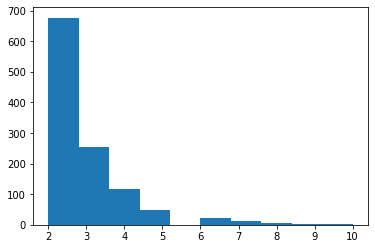

In [ ]:
plt.hist(incorrect_preds_y)

Text(0.5, 0, 'Ranking')

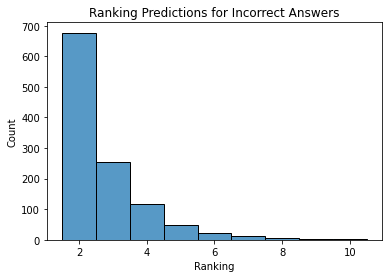

In [19]:
import seaborn as sns

fig = sns.histplot(incorrect_preds_y, binwidth=1, discrete=True)
fig.set_title("Ranking Predictions for Incorrect Answers")
fig.set_xlabel("Ranking")

In [ ]:
incorrect_preds[list(incorrect_preds.keys())[0]]

[(55665839, 1),
 (55644071, 3),
 (55644063, 2),
 (43736281, 10),
 (56789874, 9),
 (61598381, 7),
 (38446230, 8),
 (57796365, 6),
 (60590369, 4),
 (37491434, 5)]

In [ ]:
ids = []

for key, value in ea_preds_ranking_dict.items():
  rankings = set()
  for v in value:
    rankings.add(v[0])

  if len(rankings) < 10 and not 1 in rankings:
    ids.append(key)

In [ ]:
len(ids)

26

In [ ]:
ids2 = []

for key, value in qa_dict_dev.items():
  rankings = set()
  for v in value:
    rankings.add(v[0])

  if len(rankings) < 10 and not 1 in rankings:
    ids2.append(key)

In [ ]:
len(ids2)

20

In [ ]:
ids3 = []

for key, value in qa_dict_train.items():
  rankings = set()
  for v in value:
    rankings.add(v[0])

  if len(rankings) < 10 and not 1 in rankings:
    ids3.append(key)

In [ ]:
len(ids3)

28

In [ ]:
#example question and answer is for bad prediction in paper

In [13]:
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/raw_data_preprocessed.csv')
df.head(5)

,question_id,question_title_raw,question_body_raw,question_body,question_body_text,question_body_code,question_title_body_raw,question_title_body,question_title_body_text,question_title_body_code,answer_id,answer_body_raw,answer_body,answer_text,answer_code,answer_count,view_count,answer_score,is_accepted_answer,question_title_body_order_textcode,question_title_body_order_codetext,answer_body_order_textcode,answer_body_order_codetext
0,55661532,"When I run my socket program, there get: `impo...",<p>I write a socket server programmer:</p>\n\n...,I write a socket server programmer:\n#-*- codi...,I write a socket server programmer:\n\nwhen I ...,#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,"When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...",#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,55661630,<p>The answer to your new question is that you...,The answer to your new question is that you ca...,The answer to your new question is that you ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,1816,0,0,"When I run my socket program, there get: `impo...",#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,The answer to your new question is that you ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE..."
1,55661626,"with socket.socket(socket.AF_INET, socket.SOCK...",<p>I have a socket server program:</p>\n\n<pre...,I have a socket server program:\n#!/usr/bin/en...,I have a socket server program:\n\nwhen I run ...,#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,"with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...",#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,55661660,<p>You can't use <code>socket.socket(socket.AF...,"You can't use socket.socket(socket.AF_INET, so...",You can't use with . So that a statement ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,2521,0,1,"with socket.socket(socket.AF_INET, socket.SOCK...",#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,You can't use with . So that a statement ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE..."
2,55661929,How to display 5 numbers per line from a list?,<p>How to display 5 numbers per line from a li...,How to display 5 numbers per line from a list?...,How to display 5 numbers per line from a list?...,"lx = [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,...",How to display 5 numbers per line from a list?...,How to display 5 numbers per line from a list?...,How to display 5 numbers per line from a list?...,"lx = [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,...",55662134,<p>There can be different approaches to the pr...,There can be different approaches to the probl...,There can be different approaches to the probl...,x=[] #your given list\nfor t in range(len(x))...,4,125,0,0,How to display 5 numbers per line from a list?...,"lx = [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,...",There can be different approaches to the probl...,x=[] #your given list\nfor t in range(len(x))...
3,55662778,create list with spectial type - Spyder error ...,<p>I want to print <code>&gt;</code> in the sc...,I want to print > in the script 0 to test the ...,I want to print in the script 0 to test the c...,>script[0][4][2]name 'script' is not defined\n...,create list with spectial type - Spyder error ...,create list with spectial type - Spyder error ...,create list with spectial type - Spyder error ...,>script[0][4][2]name 'script' is not defined\n...,55662821,<p>Define list as <code>[]</code> and use <cod...,Define list as [] and use append to add elemen...,Define list as and use to add elements to li...,"[]appendscript = []\n\nscript.append(['A','A',...",2,24,0,1,create list with spectial type - Spyder error ...,>script[0][4][2]name 'script' is not defined\n...,Define list as and use to add elements to li...,"[]appendscript = []\n\nscript.append(['A','A',..."
4,55662778,create

In [20]:
#Get question title lengths
question_lengths = []
answer_lengths = []

for key in incorrect_preds_x:
  # print(len(df[(df.question_id == key) & (df.is_accepted_answer == 1)]['question_title_body'].item()))
  question_lengths.append(len(df[(df.question_id == key) & (df.is_accepted_answer == 1)]['question_title_body_text'].item().split()))
  answer_lengths.append(len(str(df[(df.question_id == key) & (df.is_accepted_answer == 1)]['answer_text'].item()).split()))


77.72207563764292


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Lengths (# of words)')

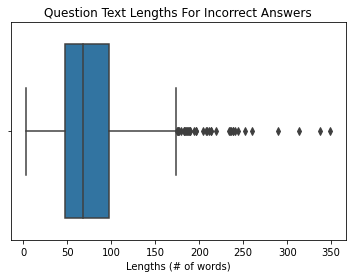

In [21]:
print(np.mean(question_lengths))
fig = sns.boxplot(question_lengths)
fig.set_title("Question Text Lengths For Incorrect Answers")
fig.set_xlabel("Lengths (# of words)")

45.21372031662269


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Lengths (# of words)')

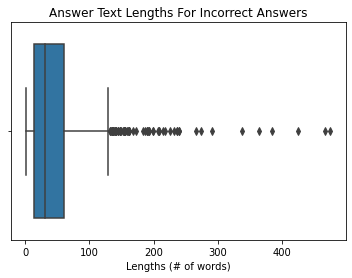

In [22]:
print(np.mean(answer_lengths))
fig = sns.boxplot(answer_lengths)
fig.set_title("Answer Text Lengths For Incorrect Answers")
fig.set_xlabel("Lengths (# of words)")

In [23]:
#Get question title lengths
question_code_lengths = []
answer_code_lengths = []

for key in incorrect_preds_x:
  # print(len(df[(df.question_id == key) & (df.is_accepted_answer == 1)]['question_title_body'].item()))
  # print(len(str(df[(df.question_id == key) & (df.is_accepted_answer == 1)]['question_title_body_code'].item()).split()))
  question_code_lengths.append(len(str(df[(df.question_id == key) & (df.is_accepted_answer == 1)]['question_title_body_code'].item()).split()))
  answer_code_lengths.append(len(str(df[(df.question_id == key) & (df.is_accepted_answer == 1)]['answer_code'].item()).split()))


56.68337730870712


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Lengths (# of words)')

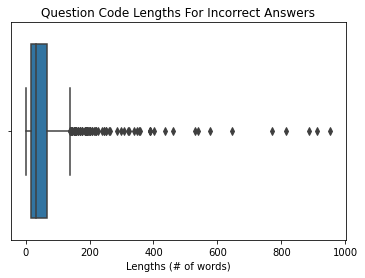

In [24]:
print(np.mean(question_code_lengths))
fig = sns.boxplot(question_code_lengths)
fig.set_title("Question Code Lengths For Incorrect Answers")
fig.set_xlabel("Lengths (# of words)")

39.34564643799472


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Lengths (# of words)')

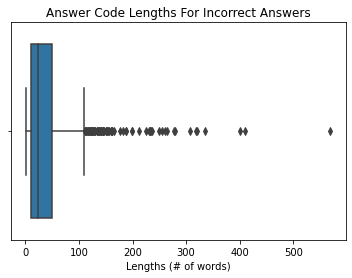

In [25]:
print(np.mean(answer_code_lengths))
fig = sns.boxplot(answer_code_lengths)
fig.set_title("Answer Code Lengths For Incorrect Answers")
fig.set_xlabel("Lengths (# of words)")

# Checking the answers that were ranked second

In [14]:
# Get all question IDs that had incorrect predictions

incorrect_preds_2_rank = {}

for key, value in qa_dict_test.items():
  correct_answer_position = [i for i in range(len(value)) if value[i][1] == 1]
  # print(ea_preds_ranking_dict[key][correct_answer_position[0]][1])
  if ea_preds_ranking_dict[key][correct_answer_position[0]][1] == 2:
    incorrect_preds_2_rank[key] = ea_preds_ranking_dict[key]
    # incorrect_preds_x.append(key)
    # incorrect_preds_y.append(ea_preds_ranking_dict[key][correct_answer_position[0]][1])

In [24]:
len(incorrect_preds_2_rank)

677

In [15]:
ua = []

for key, value in incorrect_preds_2_rank.items():
  count = 0
  for v in value:
    try:
      d = df[(df.question_id == key) & (df.answer_id == v[0])]['question_title_body'].item()
    except:
      count += 1
    
  ua.append(count)

In [16]:
sum(ua) / len(ua)

7.698670605612999

In [17]:
ua2 = []

for key, value in ea_preds_ranking_dict.items():
  count = 0
  for v in value:
    try:
      d = df[(df.question_id == key) & (df.answer_id == v[0])]['question_title_body'].item()
    except:
      count += 1
    
  ua2.append(count)

In [19]:
sum(ua2) / len(ua2)

8.045706823375776

Text(0.5, 0, '# Of Unrelated Answers')

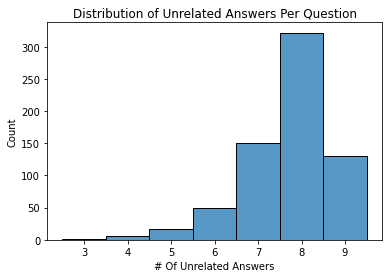

In [63]:
fig = sns.histplot(ua, binwidth=1, discrete=True)
fig.set_title("Distribution of Unrelated Answers Per Question")
fig.set_xlabel("# Of Unrelated Answers")

Text(0.5, 0, '# Of Unrelated Answers')

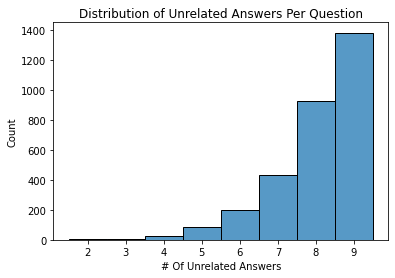

In [21]:
import seaborn as sns

fig = sns.histplot(ua2, binwidth=1, discrete=True)
fig.set_title("Distribution of Unrelated Answers Per Question")
fig.set_xlabel("# Of Unrelated Answers")

In [25]:
incorrect_preds_2_rank[list(incorrect_preds_2_rank.keys())[0]]

[(55665839, 1),
 (55644071, 3),
 (55644063, 2),
 (43736281, 10),
 (56789874, 9),
 (61598381, 7),
 (38446230, 8),
 (57796365, 6),
 (60590369, 4),
 (37491434, 5)]

In [26]:
list(incorrect_preds_2_rank.keys())[0]

55644043

In [52]:
unrelated_ans = 0

for i in incorrect_preds_2_rank[list(incorrect_preds_2_rank.keys())[0]]:
  try:
    d = df[(df.question_id == 55644043) & (df.answer_id == i[0])]['question_title_body'].item()
  except:
    unrelated_ans += 1

print(unrelated_ans)

7


In [37]:
# Question JOHN, THIS IS THE FIRST EXAMPLE CELL
print(df[(df.question_id == 55644043) & (df.answer_id == 55644063)]['question_title_body'].item())
print()
print(len(df[(df.question_id == 55644043) & (df.answer_id == 55644063)]['question_title_body'].item().split()))
print(len(df[(df.question_id == 55644043) & (df.answer_id == 55644063)]['question_title_body_text'].item().split()))
print(len(df[(df.question_id == 55644043) & (df.answer_id == 55644063)]['question_title_body_code'].item().split()))

Accessing the value of a zip object using its indexI am trying to understand how to access a zip object and I'm trying to figure out how to access the value in the zipped object using the index by using the .index() just as we have it before in Python 2.x but it seemed that it does not work in Python3 
Here is the code
def find_neighbors(index):
    i, j = index
    print([(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)])
    return [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]

list1 = (211,209,210,210)
list2 = (72,72,73,71)
points = zip(list1,list2)

for i, index in enumerate(points):
    for x in find_neighbors(index):
          if x is not in points: continue
          j = points.index(x)

When I run the code, I am getting this error: AttributeError: 'zip' object has no attribute 'index'
Is there a new way on how to execute this same mechanism

161
94
67


In [36]:
# Correct answer ID but ranked second
print(df[(df.question_id == 55644043) & (df.answer_id == 55644063)]['answer_body'].item())
print()
print(len(df[(df.question_id == 55644043) & (df.answer_id == 55644063)]['answer_body'].item().split()))
print(len(df[(df.question_id == 55644043) & (df.answer_id == 55644063)]['answer_text'].item().split()))
print(len(df[(df.question_id == 55644043) & (df.answer_id == 55644063)]['answer_code'].item().split()))

It seems like you expect points to be a list, but zip objects are not lists.
If you want to convert it to a list, then do this:
points = list(zip(list1,list2))


31
26
3


In [38]:
# Wrong answer ID but ranked first
print(df[(df.question_id == 55644043) & (df.answer_id == 55665839)]['answer_body'].item())
print()
print(len(df[(df.question_id == 55644043) & (df.answer_id == 55665839)]['answer_body'].item().split()))
print(len(df[(df.question_id == 55644043) & (df.answer_id == 55665839)]['answer_text'].item().split()))
print(len(df[(df.question_id == 55644043) & (df.answer_id == 55665839)]['answer_code'].item().split()))

As the others say: zip returns a zip object which is an iterator you can use to make other things like a list or a dictionary. Also, (a,b,c) returns a tuple whereas [a,b,c] returns a list.
>>> type((1,2,3))
<class 'tuple'>
>>> type([1,2,3])
<class 'list'>
>>> 

It may not matter to you unless you want to start modifying the contents of the "lists". You called them "lists" so I have made them lists below. In either case, once you zip them up and convert to a list (list(zip(list1,list2)), you get a list of tuples. In fact this makes your code a little easier because you can pass the tuple into your function:
def find_neighbors(point):
i = point[0]
j = point[1]
print(f"List of neighbours of {point}: {[(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]}")
return [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]

list1 = [211,209,210,210,211]
list2 = [72,72,73,71,73]
pointsList = list(zip(list1,list2))

#These loops are just to show what is going on comment them out or delete them
for i in poin

In [ ]:
# STOP

In [43]:
incorrect_preds_2_rank[list(incorrect_preds_2_rank.keys())[5]]

[(56043008, 3),
 (56042981, 2),
 (56042851, 1),
 (47044827, 6),
 (59342866, 7),
 (63141651, 5),
 (46260653, 8),
 (35066631, 9),
 (62987942, 10),
 (40697969, 4)]

In [33]:
list(incorrect_preds_2_rank.keys())[5]

56042792

In [54]:
unrelated_ans2 = 0

for i in incorrect_preds_2_rank[list(incorrect_preds_2_rank.keys())[5]]:
  try:
    d = df[(df.question_id == 56042792) & (df.answer_id == i[0])]['question_title_body'].item()
  except:
    unrelated_ans2 += 1

print(unrelated_ans2)

7


In [39]:
print(df[(df.question_id == 56042792) & (df.answer_id == 56042981)]['question_title_body'].item())
print()
print(len(df[(df.question_id == 56042792) & (df.answer_id == 56042981)]['question_title_body'].item().split()))
print(len(df[(df.question_id == 56042792) & (df.answer_id == 56042981)]['question_title_body_text'].item().split()))
print(len(df[(df.question_id == 56042792) & (df.answer_id == 56042981)]['question_title_body_code'].item().split()))

python: Reorder list of strings first numerically, than alphabeticallyI am beginner in python lists. I have a list of feature classes named by type and year of occurrence: feature class "a_05" occurred in 2005, feature class "b_03" occurred in 2003.
I would like to sort the items in a list increasingly by time they occurred (2003, 2005...), and if two types occurred in the same year, than they should be ordered alphabetically.  
Let's say, list 
fcs = [u'b_02', u'a_05', u'a_03', u'b_03']

should results in [ u'b_02', u'a_03', u'b_03', u'a_05'], 
i.e. first years (_02,_03,_03,_05) and then alphabetically u'a_03', u'b_03'. 
Using simply fcs.sort() my items are instead first sorted alphabetically, than by numbers: [u'a_03', u'a_05', u'b_02', u'b_03']
How can I alter my item names to be able to sort them first by numbers, not by the letters?

135
118
15


In [41]:
print(df[(df.question_id == 56042792) & (df.answer_id == 56042981)]['answer_body'].item())
print()
print(len(df[(df.question_id == 56042792) & (df.answer_id == 56042981)]['answer_body'].item().split()))
print(len(df[(df.question_id == 56042792) & (df.answer_id == 56042981)]['answer_text'].item().split()))
print(len(df[(df.question_id == 56042792) & (df.answer_id == 56042981)]['answer_code'].item().split()))

fcs = [u'b_02', u'a_05', u'a_03', u'b_03']
fcs.sort(key=lambda x:[int(x.split('_')[1]),x.split('_')[0]])

output
['b_02', 'a_03', 'b_03', 'a_05']

full documentation for using lambda here
here  i am making an order to sort, sort  list with method 1 and if in method 1 got few value which are same then sort those same values with the method 2 (it's like nested sorting). order to sort is defined in a list. 
method 1 : x.split('_')[1]] # on bases of integer
method 2 : x.split('_')[0]] # on bases of alphabets
PS. sorry i am bad at explaining stuff. 

90
78
12


In [42]:
print(df[(df.question_id == 56042792) & (df.answer_id == 56042851)]['answer_body'].item())
print()
print(len(df[(df.question_id == 56042792) & (df.answer_id == 56042851)]['answer_body'].item().split()))
print(len(df[(df.question_id == 56042792) & (df.answer_id == 56042851)]['answer_text'].item().split()))
print(len(df[(df.question_id == 56042792) & (df.answer_id == 56042851)]['answer_code'].item().split()))

Using sorted with a custom key.
Ex:
fcs = [u'b_02', u'a_05', u'a_03', u'b_03']
print(sorted(fcs, key=lambda x: int(x.split("_")[1])))

or sort
Ex:
fcs = [u'b_02', u'a_05', u'a_03', u'b_03']
fcs.sort(key=lambda x: int(x.split("_")[1]))
print(fcs)

Output:
['b_02', 'a_03', 'b_03', 'a_05']

Using the lambda function to split the element by _ and then converting it to int

51
22
25


In [27]:
incorrect_preds_2_rank[list(incorrect_preds_2_rank.keys())[20]]

[(53796972, 3),
 (53796891, 1),
 (53796912, 7),
 (53797003, 5),
 (53796934, 2),
 (41993886, 4),
 (43835609, 10),
 (46580822, 8),
 (44994915, 6),
 (52995581, 9)]

In [28]:
list(incorrect_preds_2_rank.keys())[20]

53796842

In [55]:
unrelated_ans3 = 0

for i in incorrect_preds_2_rank[list(incorrect_preds_2_rank.keys())[20]]:
  try:
    d = df[(df.question_id == 53796842) & (df.answer_id == i[0])]['question_title_body'].item()
  except:
    unrelated_ans3 += 1

print(unrelated_ans3)

5


In [43]:
print(df[(df.question_id == 53796842) & (df.answer_id == 53796934)]['question_title_body'].item())
print()
print(len(df[(df.question_id == 53796842) & (df.answer_id == 53796934)]['question_title_body'].item().split()))
print(len(df[(df.question_id == 53796842) & (df.answer_id == 53796934)]['question_title_body_text'].item().split()))
print(len(df[(df.question_id == 53796842) & (df.answer_id == 53796934)]['question_title_body_code'].item().split()))

How to generate dict from list of lists with possible empty values?I have list of lists: dep = [['ArithmeticError'], ['ZeroDivisionError', 'ArithmeticError'], ['OSError'], ['FileNotFoundError', 'OSError']] and I need to convert it to dict like: dep = {'ArithmeticError': None, 'ZeroDivisionError': 'ArithmeticError', 'OSError': None, 'FileNotFoundError': 'OSError'}. Also it possible to have list of strings as value with  some names of errors.
I saw variants with dict(), but it doesn't work for me because empty values is possible.
I tried to use dep = dict(dep), but I have error: "dictionary update sequence element #0 has length 1; 2 is required".

96
77
19


In [44]:
print(df[(df.question_id == 53796842) & (df.answer_id == 53796934)]['answer_body'].item())
print()
print(len(df[(df.question_id == 53796842) & (df.answer_id == 53796934)]['answer_body'].item().split()))
print(len(df[(df.question_id == 53796842) & (df.answer_id == 53796934)]['answer_text'].item().split()))
print(len(df[(df.question_id == 53796842) & (df.answer_id == 53796934)]['answer_code'].item().split()))

You could add None to the end of each sublist, then take the first two items.
dep = dict((sublist + [None])[:2] for sublist in dep)

e.g. using pprint to print nicely
>>> dep = [['ArithmeticError'],
...        ['ZeroDivisionError', 'ArithmeticError'],
...        ['OSError'],
...        ['FileNotFoundError', 'OSError']]

>>> from pprint import pprint

>>> result = dict((sublist + [None])[:2] for sublist in dep)

>>> pprint(result)
{'ArithmeticError': None,
 'FileNotFoundError': 'OSError',
 'OSError': None,
 'ZeroDivisionError': 'ArithmeticError'}

edit: To perhaps be clearer we could also use itemgetter to give a name to what we're returning:
>>> from operator import itemgetter
>>> first_two = itemgetter(0, 1)

>>> first_two(['ZeroDivisionError', 'ArithmeticError', None])
('ZeroDivisionError', 'ArithmeticError')

Then the above solution becomes:
>>> result = dict(first_two(sublist + [None]) for sublist in dep)


117
42
72


In [45]:
print(df[(df.question_id == 53796842) & (df.answer_id == 53796891)]['answer_body'].item())
print()
print(len(df[(df.question_id == 53796842) & (df.answer_id == 53796891)]['answer_body'].item().split()))
print(len(df[(df.question_id == 53796842) & (df.answer_id == 53796891)]['answer_text'].item().split()))
print(len(df[(df.question_id == 53796842) & (df.answer_id == 53796891)]['answer_code'].item().split()))

You can do this:
dep = [['ArithmeticError'], ['ZeroDivisionError', 'ArithmeticError'],
   ['OSError'], ['FileNotFoundError', 'OSError']]

dep_dict = {}

for val in dep:
    if len(val) == 1:
        dep_dict[val[0]] = None
    else:
        dep_dict[val[0]] = val[1]

This works by making the dictionary dep_dict and assigning it's keys to be the values of dep and their values to either None or the second item in the corresponding list.

61
32
27


# Checking the answers that were ranked 10

In [46]:
# Get all question IDs that had incorrect predictions

incorrect_preds_10 = {}

for key, value in qa_dict_test.items():
  correct_answer_position = [i for i in range(len(value)) if value[i][1] == 1]
  # print(ea_preds_ranking_dict[key][correct_answer_position[0]][1])
  if ea_preds_ranking_dict[key][correct_answer_position[0]][1] in [10]:
    incorrect_preds_10[key] = ea_preds_ranking_dict[key]
    # incorrect_preds_x.append(key)
    # incorrect_preds_y.append(ea_preds_ranking_dict[key][correct_answer_position[0]][1])

In [51]:
len(incorrect_preds_10)

2

In [52]:
incorrect_preds_10[list(incorrect_preds_10.keys())[0]]

[(65083336, 5),
 (65083338, 10),
 (41262265, 4),
 (37470582, 1),
 (55148159, 8),
 (36885708, 2),
 (59285749, 7),
 (54301314, 9),
 (40313673, 3),
 (44664378, 6)]

In [53]:
list(incorrect_preds_10.keys())[0]

65083321

In [49]:
unrelated_answers = 0

for i in incorrect_preds_10[list(incorrect_preds_10.keys())[0]]:
  try:
    d = df[(df.question_id == 65083321) & (df.answer_id == i[0])]['question_title_body'].item()
  except:
    unrelated_answers += 1

print(unrelated_answers)

8


In [54]:
df[(df.question_id == 65083321) & (df.answer_id == 65083338)]['question_title_body'].item()

"How to print selected numbers from a list in python?I want to print all atoms except H (hydrogen) from the pdb file. Here is the file\nhttps://github.com/mahesh27dx/molecular_phys.git\nFollowing code prints the objects of the file\nimport numpy as np\nimport mdtraj as md\n\ncoord = md.load('alanine-dipeptide-nowater.pdb')\natoms, bonds = coord.topology.to_dataframe()\natoms\n\nThe result looks like this\n\nFrom this table I want to print all the elements except H . I think it can be done in python using the list slicing. Could someone have any idea how it can be done?\nThanks!"

In [55]:
# Correct answer ranked as 10
df[(df.question_id == 65083321) & (df.answer_id == 65083338)]['answer_body'].item()

"You probably should clarify that you want help with mdtraj or pandas specifically.\nAnyway, it's as simple as atoms.loc[atoms.element != 'H']."

In [64]:
# Wrong answer predicted as 1
df[df.answer_id == 37470582]['answer_body'].item()

"for index,item in enumerate(p):\n     print 'top', index     #The index is at this level\n     for x in range(len(item)):\n         print 'loop' ,index  # Not this level where you print it. \n"

In [65]:
incorrect_preds_10[list(incorrect_preds_10.keys())[1]]

[(34966432, 10),
 (57764215, 3),
 (53968083, 9),
 (36947104, 8),
 (43631155, 5),
 (49562626, 6),
 (55020451, 4),
 (56133025, 2),
 (36947104, 8),
 (45808006, 1)]

In [63]:
list(incorrect_preds_10.keys())[1]

34965758

In [51]:
unrelated_answers2 = 0

for i in incorrect_preds_10[list(incorrect_preds_10.keys())[1]]:
  try:
    d = df[(df.question_id == 34965758) & (df.answer_id == i[0])]['question_title_body'].item()
  except:
    unrelated_answers2 += 1

print(unrelated_answers2)

9


In [66]:
df[(df.question_id == 34965758) & (df.answer_id == 34966432)]['question_title_body'].item()

'python script for value extraction, split data and reformatThis question is largely related to logic and somewhat to syntax. \nI\'m creating a short python script to extract just some few "tidbits" of information from many hundreds of records. So far I\'m pretty close but the code requires a modification which I\'m seemingly incapable of formulating. \nI have data of the following form:\n368 1   "Overall evaluation: 1\nInvite to interview: 1\nStrength or novelty of the idea (1): 2\nStrength or novelty of the idea (2): 3\nStrength or novelty of the idea (3): 2\nUse or provision of open data (1): 2\nUse or provision of open data (2): 2\n""Open by default"" (1): 3\n""Open by default"" (2): 2\nValue proposition and potential scale (1): 2\nValue proposition and potential scale (2): 2\nMarket opportunity and timing (1): 2\nMarket opportunity and timing (2): 1\nTriple bottom line impact (1): 2\nTriple bottom line impact (2): 2\nTriple bottom line impact (3): 2\nKnowledge and skills of the te

In [67]:
# Correct answer predicted as 10
df[(df.question_id == 34965758) & (df.answer_id == 34966432)]['answer_body'].item()

'This is what I would\'ve done. This does your job, not perfectly but does it.\nAlso, 1.txt is the same text as yours.\n#!/usr/bin/python\n\nf=open("1.txt",\'r\').read().splitlines()\nhead=\'0\'\nbody=[]\nfor x in f:\n    if x=="\\n" or x.strip()==\'\':\n        continue\n    try:\n        int(x[0])\n        print(head +\':\'+\'+\'.join(body))\n        tmp=x.split()\n        head=tmp[0]+\'-\'+tmp[1]\n        body=[tmp[4]]\n    except ValueError as e:\n        body.append(x.split(\':\')[1].strip().strip(\'\\"\'))\nprint(head +\':\'+\'+\'.join(body))\n\nOutput would be:\n0:\n299-1:3+3+4+3+3+4+3+2+3+4+2+4+4+4+2+2+3+4+4+3+4+3\n299-2:3+3+3+2+4+4+3+3+2+4+3+4+3+3+2+1+4+4+4+4+4+2\n364-1:3+3+4+1+3+3+3+3+3+4+4+4+4+4+4+3+3+3+4+3+3+3\n364-2:3+3+4+3+3+4+4+4+3+4+3+2+3+4+4+1+3+3+2+4+4+2\n\nNow you can skip the first print by adding a check for length of the array, so you don\'t print the 0: line.'

In [69]:
# Wrong answer predicted as 1
df[df.answer_id == 45808006]['answer_body'].item()

"You can construct a list (or generator) of dict and pass it to pandas, e.g.:\nIn []:\nimport pandas as pd\nwith open('<file>') as f\n    df = pd.DataFrame(dict(x.split('.') for x in line.strip().split('#') if x) for line in f)\ndf\n\nOut[]:\n  S2_P1 S2_P10    S2_P2    S2_P3    S2_P4 S2_P5    S2_P6 S2_P7    S2_P8    S2_P9  \n0     2      0  default  default  default     2  default     2  default  default   \n1     0      0  default  default  default     0  default     0  default  default\n2     3      0  default  default  default     3  default     3  default  default\n3     2      0        2        2        2     2        2     2        2        0\n4     1      0  default  default  default     1  default     1  default  default\n"